In [101]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
data = pd.read_csv('spooky-authors.csv')
test = pd.read_csv('spooky-author-test.csv')

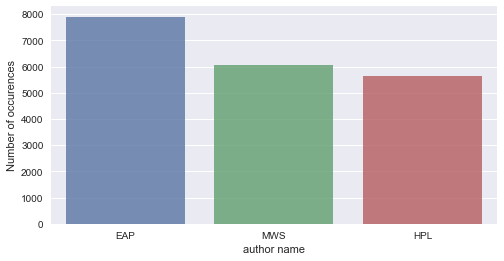

In [13]:
authors = data.author.value_counts()
plt.figure(figsize=(8,4))
sns.barplot(authors.index, authors.values, alpha=0.8)
plt.ylabel('Number of occurences')
plt.xlabel('author name')
plt.show()

In [45]:
data['num_words'] = data['text'].map(lambda x: len(x.split()))
data['num_unique_words'] = data['text'].map(lambda x: len(set(x.split())))
data['num_chars'] = data['text'].map(lambda x: len(x))
data['num_stopwords'] = data['text'].map(lambda x: len([w for w in x if w in stopwords.words('english')]))
data['num_specialchars'] = data['text'].map(lambda x: len([c for c in str(x) if c in string.punctuation]))
data['num_words_upper'] = data['text'].map(lambda x: len([w for w in x.split() if w.isupper()]))
data['num_words_title'] = data['text'].map(lambda x: len([w for w in x.split() if w.istitle()]))
data['mean_word_length'] = data['text'].map(lambda x: np.mean([len(w) for w in x.split()]))

In [39]:
test['num_words'] = test['text'].map(lambda x: len(x.split()))
test['num_unique_words'] = test['text'].map(lambda x: len(set(x.split())))
test['num_chars'] = test['text'].map(lambda x: len(x))
test['num_stopwords'] = test['text'].map(lambda x: len([w for w in x if w in stopwords.words('english')]))
test['num_specialchars'] = test['text'].map(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['num_words_upper'] = test['text'].map(lambda x: len([w for w in x.split() if w.isupper()]))
test['num_words_title'] = test['text'].map(lambda x: len([w for w in x.split() if w.istitle()]))
test['mean_word_length'] = test['text'].map(lambda x: np.mean([len(w) for w in x.split()]))

/Users/agrimabahl/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


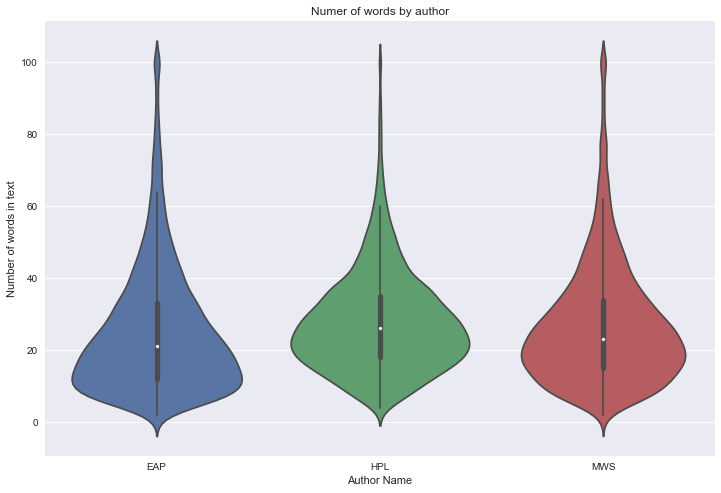

In [46]:
data.num_words.loc[data.num_words>100] = 100
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=data)
plt.xlabel('Author Name')
plt.ylabel('Number of words in text')
plt.title('Number of words by author')
plt.show()

/Users/agrimabahl/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


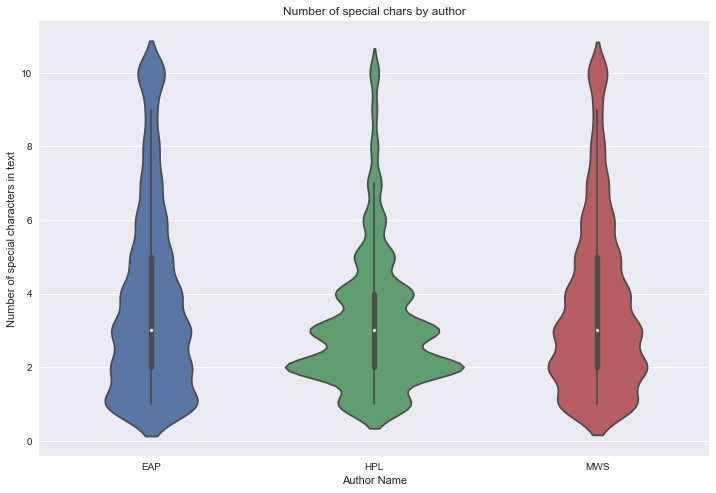

In [57]:
data.num_specialchars.loc[data.num_specialchars>10] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_specialchars', data=data)
plt.xlabel('Author Name')
plt.ylabel('Number of special characters in text')
plt.title('Number of special chars by author')
plt.show()

In [67]:
author_mapping = {'EAP': '0', 'HPL': '1', 'MWS': '2'}
train_y = data.author.map(author_mapping)
train_id = data.id.values
test_id = data.id.values

data['num_words'] = data['text'].map(lambda x: len(x.split()))
test['num_words'] = test['text'].map(lambda x: len(x.split()))
data['mean_word_length'] = data['text'].map(lambda x: np.mean([len(w) for w in x.split()]))
test['mean_word_length'] = test['text'].map(lambda x: np.mean([len(w) for w in x.split()]))

cols_to_keep = ['num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_specialchars', 'num_words_upper',
       'num_words_title', 'mean_word_length']
train_X = data[cols_to_keep].copy()
test_X = test[cols_to_keep].copy()

In [102]:
def pred_with_xgb(train_X, train_y, test_X, seedval=0, child=1, colsample=0.3):
    param={}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seedval
    num_rounds = 2000
    
    plst = list(param.items())
    xgbtrain = xgb.DMatrix(train_X, label=train_y)
    
    xgbtest = xgb.DMatrix(test_X)
    model = xgb.train(plst, xgbtrain, num_rounds)
    
    pred_test_y = model.predict(xgbtest, ntree_limit=model.best_ntree_limit)
    return pred_test_y, model

In [99]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
cv_scores=[]
pred_full_test = 0
for train_index, test_index in kf.split(train_X):
    train, test = train_X.loc[train_index], train_X.loc[test_index]
    train_label, test_label = train_y[train_index], train_y.loc[test_index]
    pred_val_y, model = pred_with_xgb(train, train_label, test)
    # pred_full_test = pred_full_test + pred_test_y
    cv_scores.append(metrics.log_loss(test_label, pred_val_y))
print("cv_scores:", cv_scores)

cv_scores: [1.033541465853317, 1.0227529929835013, 1.0170795968512552, 1.0341040473692957, 1.0245114820746475]


In [110]:
pred_vals_test, model = pred_with_xgb(train_X, train_y, test_X)

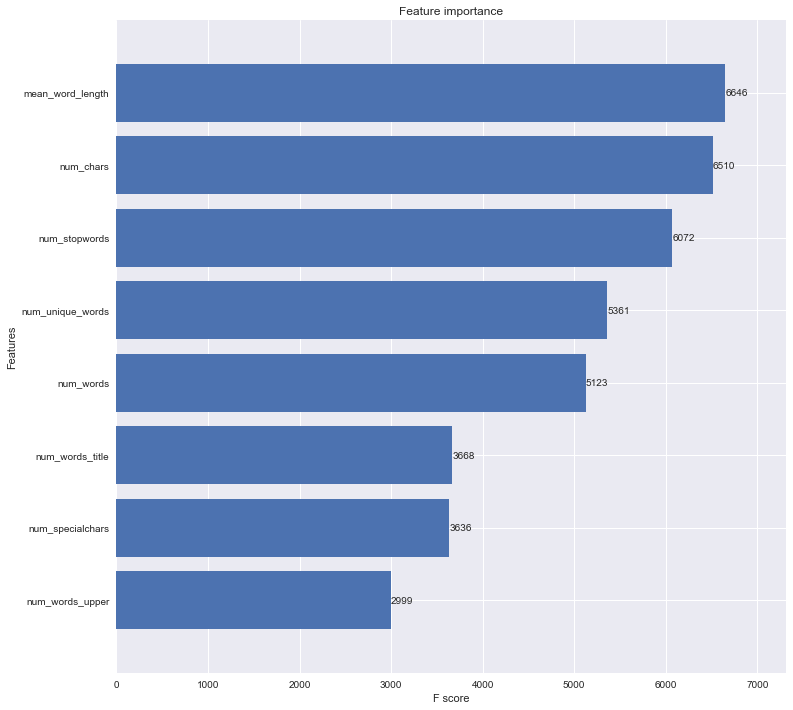

In [111]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [133]:
preds = pd.DataFrame(pred_vals_test, columns=['EAP', 'HPL', 'MWS'])
test_id = pd.DataFrame(test_id, columns=['id'])

In [135]:
predict = pd.concat([test_id, preds], axis=1)

In [139]:
predict.to_csv('spooky.csv', index=False)